# Initialize the accelerator

In [1]:
from finn_examples import models
print(list(filter(lambda x: "cifar10" in x, dir(models))))

['_cifar10_cnv_io_shape_dict', 'cnv_w1a1_cifar10', 'cnv_w1a2_cifar10', 'cnv_w2a2_cifar10']


In [2]:
accel = models.cnv_w1a1_cifar10()

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 32, 32, 3) DataType.UINT8
Expected output shape and datatype: (1, 1) DataType.UINT8


# Load the CIFAR-10 dataset

Use the `dataset_loading` package to get easy Python access to CIFAR-10 dataset:

In [5]:
from dataset_loading import cifar
trainx, trainy, testx, testy, valx, valy = cifar.load_cifar_data("/tmp", download=True, one_hot=False)

Tar File found in dest_dir. Not Downloading again
Extracting Python CIFAR10 data.
Files extracted


In [6]:
testx.shape

(10000, 32, 32, 3)

# Classify a single image

In [7]:
test_single_x = testx[0]
test_single_y = testy[0]
cifar10_class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


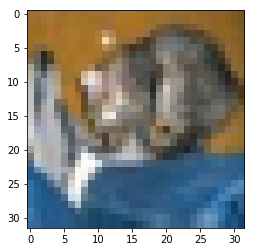

In [9]:
from matplotlib import pyplot as plt

plt.imshow(test_single_x)
plt.show()

In [10]:
print("Expected class is %d (%s)" % (test_single_y, cifar10_class_names[test_single_y]))

Expected class is 3 (Cat)


In [11]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 32, 32, 3) and datatype is uint8


In [12]:
accel_out = accel.execute(accel_in)

In [13]:
print("Returned class is %d" % accel_out)

Returned class is 3


In [14]:
%%timeit
accel_out = accel.execute(accel_in)

100 loops, best of 3: 2.34 ms per loop


# Validate accuracy on entire CIFAR-10 test set

In [15]:
import numpy as np

batch_size = 1000
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Ready to run validation, test images tensor has shape (10, 1000, 3072)
Accelerator buffer shapes are (1000, 1, 32, 32, 1, 3) for input, (1000, 1, 1) for output


In [16]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal)
    exp = batch_labels[i]
    obuf_normal = accel.execute(ibuf_normal)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    print("batch %d / %d : total OK %d NOK %d" % (i, n_batches, ok, nok))

batch 0 / 10 : total OK 851 NOK 149
batch 1 / 10 : total OK 1683 NOK 317
batch 2 / 10 : total OK 2522 NOK 478
batch 3 / 10 : total OK 3370 NOK 630
batch 4 / 10 : total OK 4207 NOK 793
batch 5 / 10 : total OK 5044 NOK 956
batch 6 / 10 : total OK 5887 NOK 1113
batch 7 / 10 : total OK 6728 NOK 1272
batch 8 / 10 : total OK 7570 NOK 1430
batch 9 / 10 : total OK 8419 NOK 1581


In [17]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 84.19%


In [18]:
def run_validation():
    for i in range(n_batches):
        ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal)
        exp = batch_labels[i]
        accel.execute(ibuf_normal)

In [20]:
full_validation_time = %timeit -n 1 -o run_validation()

1 loop, best of 3: 3.34 s per loop


In [21]:
print("%f images per second including data movement" % (total / float(full_validation_time.best)))

2995.076851 images per second including data movement


## More benchmarking

In [23]:
accel.throughput_test()

{'DRAM_in_bandwidth[Mb/s]': 9.278965852281484,
 'DRAM_out_bandwidth[Mb/s]': 0.0030204966967062124,
 'batch_size': 1000,
 'copy_input_data_to_device[ms]': 0.0018696784973144531,
 'copy_output_data_from_device[ms]': 8.96453857421875e-05,
 'fclk[mhz]': 99.999,
 'fold_input[ms]': 4.38690185546875e-05,
 'pack_input[ms]': 6.0558319091796875e-05,
 'runtime[ms]': 331.0713768005371,
 'throughput[images/s]': 3020.496696706212,
 'unfold_output[ms]': 8.749961853027344e-05,
 'unpack_output[ms]': 0.0006213188171386719}